#### Section C: Question 5:    (15 Marks)

Develop a Semantic segmentation model using Unet architecture on the given dataset.

Dataset contains the images and the corresponding masks. Find the dataset under the folder “Unet_Dataset”. Glioma tumor images and its corresponding masks are provided.

Students can make use of pre-trained Unet segmentation model using the library

import segmentation_models as sm

Hints

1. Load all the images in one array of size 1141x128x128x1
    Where 785 is total number of trained images
    128x128x3 is each image size
2. Load all the masks in one array of size 1141x128x128x1
3. Scale both the above two arrays
4. Split the data into train and test
5. Define the pre-trained segmentation model. Use encoder_weight=None, If internet access is not available.
6. Compile with appropriate loss and metric and fit the data into it.
7. Reduce the batch_size to 1 or 2, if you get any memory related error 

Run the model for minimum 3 epochs and present your result. The solution will be evaluated based on approach only as it take lot of epochs to produce good result. 


In [1]:
import os
import cv2
from PIL import Image
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import segmentation_models as sm
from sklearn.model_selection import train_test_split
from PIL import Image
from tensorflow.keras.utils import normalize
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

Segmentation Models: using `keras` framework.


In [2]:
image_dir='Unet_Dataset/glioma_img/'

mask_dir='Unet_Dataset/glioma_mask/'

In [3]:
SIZE=128 # for a quick training, for medical images it is better to keep image size big as it is

img_dataset=[]
mask_dataset=[]

images=os.listdir(image_dir)

for i,image_name in enumerate(images):
    if (image_name.split('.')[1]=='jpg'):
        image=cv2.imread(image_dir+image_name,0)
        
        image=Image.fromarray(image)
        image=image.resize((SIZE,SIZE))
        img_dataset.append(np.array(image))
        #img_dataset.append(image)
        
        
masks=os.listdir(mask_dir)

for i,image_name in enumerate(masks):
    if (image_name.split('.')[1]=='jpg'):
        image=cv2.imread(mask_dir+image_name,0)
        image=cv2.resize(image,(SIZE,SIZE))
        (thresh, bwimage) = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY) # make sure mask is binary image
        #bwimage=Image.fromarray(bwimage)
        #mask_dataset.append(np.array(bwimage))
        mask_dataset.append(bwimage)


In [4]:
img_dataset=np.array(img_dataset)
img_dataset=normalize(img_dataset)
img_dataset=np.expand_dims(img_dataset,3)

mask_dataset=np.array(mask_dataset)
mask_dataset=mask_dataset/255.
mask_dataset=np.expand_dims(mask_dataset,3)

In [5]:
print(img_dataset.shape)

print(mask_dataset.shape)

(1141, 128, 128, 1)
(1141, 128, 128, 1)


In [6]:
np.unique(mask_dataset[0,:,:,0]) # make sure mask is having only 0 and 1 for binary class

array([0., 1.])

In [7]:
r1=np.random.randint(1,705,size=(1,2))
r1[0][0],r1[0][1]

(421, 690)

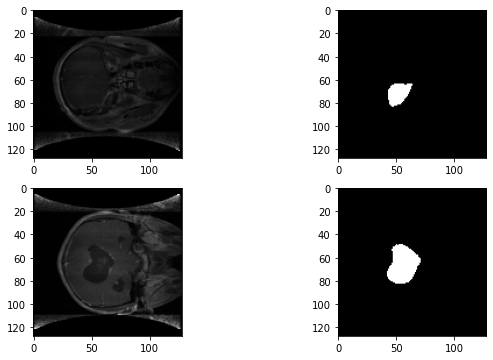

In [8]:
r1=np.random.randint(1,705,size=(1,2))
plt.figure(figsize=(10,6))
plt.subplot(2,2,1)
plt.imshow(img_dataset[r1[0][0],:,:,:].reshape(128,128),cmap='gray')
plt.subplot(2,2,2)
plt.imshow(mask_dataset[r1[0][0],:,:,:].reshape(128,128),cmap='gray')
plt.subplot(2,2,3)
plt.imshow(img_dataset[r1[0][1],:,:,:].reshape(128,128),cmap='gray')
plt.subplot(2,2,4)
plt.imshow(mask_dataset[r1[0][1],:,:,:].reshape(128,128),cmap='gray')

In [9]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(img_dataset,mask_dataset,test_size=0.15,random_state=0)

In [10]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [11]:
# preprocess input
X_train_prepr = preprocess_input(x_train)
X_test_prepr = preprocess_input(x_test)

In [12]:
del(x_train)

In [13]:
del(x_test)

In [14]:
np.unique(y_test)

array([0., 1.])

In [15]:
#model_resnet_backbone= sm.Unet(BACKBONE, encoder_weights='imagenet', encoder_freeze=True,classes=n_classes,activation='softmax')
model_resnet_backbone = sm.Unet(BACKBONE, input_shape=(128,128,1), encoder_weights=None, classes=1, activation='sigmoid')

In [16]:
#model_seg.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
#model_seg.compile(optimizer = 'adam', loss = [jacard_coef_loss], metrics = [jacard_coef])
model_resnet_backbone.compile('Adam',loss=sm.losses.bce_jaccard_loss,metrics=[sm.metrics.iou_score])
#model_resnet_backbone.compile('Adam',loss=sm.losses.bce_jaccard_loss,metrics=[sm.metrics.iou_score])

In [17]:
X_train_prepr.shape

(969, 128, 128, 1)

In [ ]:
history=model_resnet_backbone.fit(X_train_prepr, 
         y_train,
         batch_size=2, 
         epochs=3,
         verbose=1,
         validation_data=(X_test_prepr, y_test))

Epoch 1/3
485/485 [==============================] - 296s 601ms/step - loss: 1.0299 - iou_score: 0.0872 - val_loss: 1.0645 - val_iou_score: 0.0854
Epoch 2/3
485/485 [==============================] - 277s 572ms/step - loss: 0.9055 - iou_score: 0.1646 - val_loss: 0.9000 - val_iou_score: 0.1765
Epoch 3/3
142/485 [=======>......................] - ETA: 3:23 - loss: 0.8733 - iou_score: 0.1930

In [ ]:
#model_seg.compile(optimizer='Adam', loss=tf.keras.losses.BinaryCrossentropy())

In [ ]:
n1=np.random.randint(0,len(X_test_prepr))
#n1=152
test_img=X_test_prepr[n1]
test_img1=np.expand_dims(test_img,0)
pred_img=model_resnet_backbone.predict(test_img1)
pred_img1=(pred_img[0,:,:,0]>0.5).astype(np.uint8)

plt.figure(figsize=(16,8))
plt.subplot(131)
plt.title('Original')
plt.imshow(test_img[:,:,0],cmap='gray')

plt.subplot(132)
plt.title('Mask Original')
plt.imshow(y_test[n1][:,:,0],cmap='gray')

plt.subplot(133)
plt.title('Segmented Image')
plt.imshow(pred_img1,cmap='gray')